In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pywt
import numpy as np

from wvt_basis_manager_2d import WaveletBasisManager2d

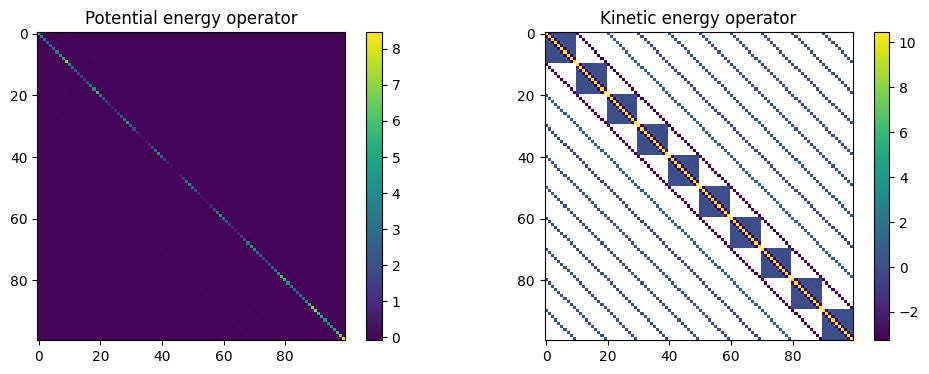

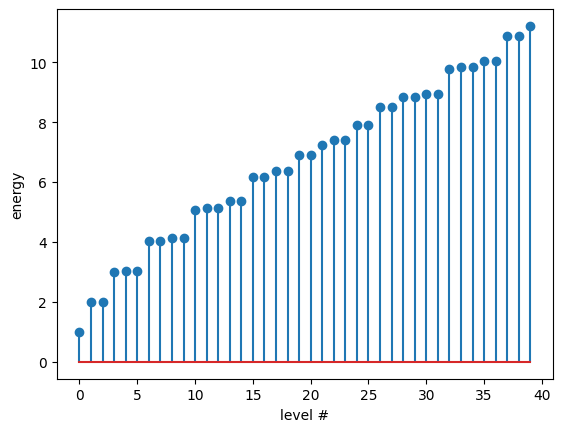

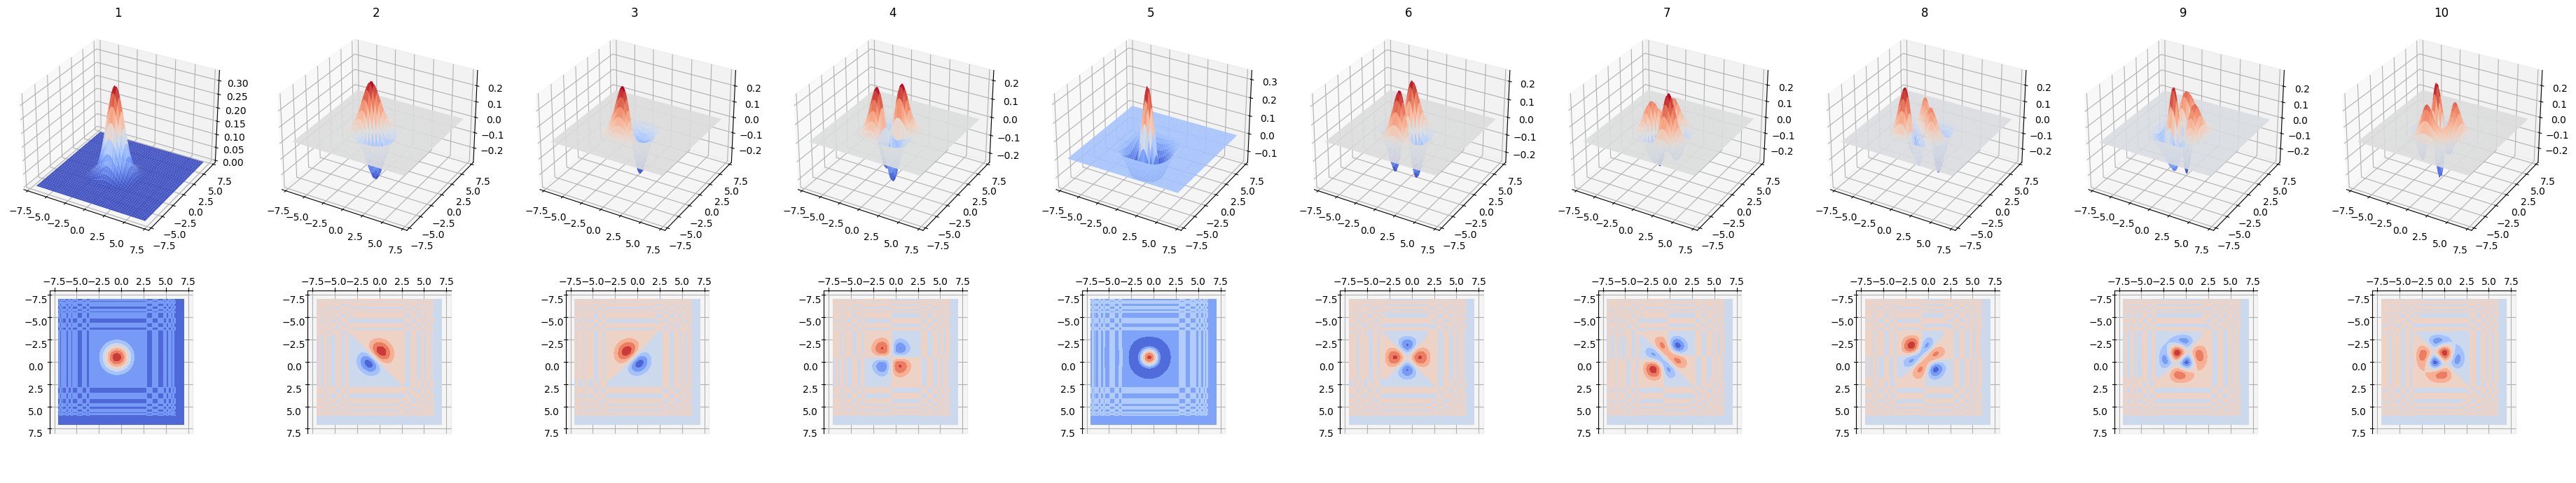

In [2]:
def experiment(
    wvt_name="sym8",
    lims_x=(-7, 7),
    lims_y=(-7, 7),
    nsteps_x=10,
    nsteps_y=10,
    do_plots=True,
    plot_levels_wavefun=10,
    plot_levels_energies=40,
    potential_func = lambda xx, yy: (xx**2 + yy**2) / 2,
):
    wvt = pywt.Wavelet(wvt_name)
    wvt_man = WaveletBasisManager2d(
        wvt,
        (nsteps_x, nsteps_y),
        lims_x,
        lims_y,
    )
    total_steps = nsteps_x * nsteps_y
    V_mat = wvt_man.get_matrix_elements(potential_func).reshape(total_steps, total_steps)
    T_mat = wvt_man.get_ke_matrix().reshape(total_steps, total_steps)

    if do_plots:
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.imshow(np.ma.masked_array(V_mat, V_mat == 0))
        plt.colorbar()
        plt.title("Potential energy operator")
        plt.subplot(1, 2, 2)
        plt.imshow(np.ma.masked_array(T_mat, T_mat == 0))
        plt.colorbar()
        plt.title("Kinetic energy operator")

    H_mat = V_mat + T_mat
    energies, states = np.linalg.eigh(H_mat)
    eigh_error = np.abs(H_mat @ states - states * energies[None, :]).max()
    if eigh_error > 1e-8:
        print("Warning: eigh error =", eigh_error)

    if do_plots:
        plt.figure()
        plt.stem(energies[:plot_levels_energies])
        plt.xlabel("level #")
        plt.ylabel("energy")

        fig, axx = plt.subplots(2, plot_levels_wavefun, figsize=(3.7 * plot_levels_wavefun, 7), subplot_kw={"projection": "3d"})
        for i in range(plot_levels_wavefun):
            ax = axx[0, i]
            xx, yy, reco_0 = wvt_man.reconstruct(states[:, i])
            xx, yy = np.meshgrid(xx, yy, indexing='ij')

            ax.plot_surface(xx, yy, reco_0, cmap=mpl.cm.coolwarm);
            ax.set_title(i + 1);

            ax = axx[1, i]
            ax.view_init(elev=90, azim=0)
            ax.set_proj_type('ortho')
            ax.set_zticks([])
            ax.contourf(xx, yy, reco_0, cmap=mpl.cm.coolwarm);

        plt.tight_layout();

    return energies

energies_10x10 = experiment()

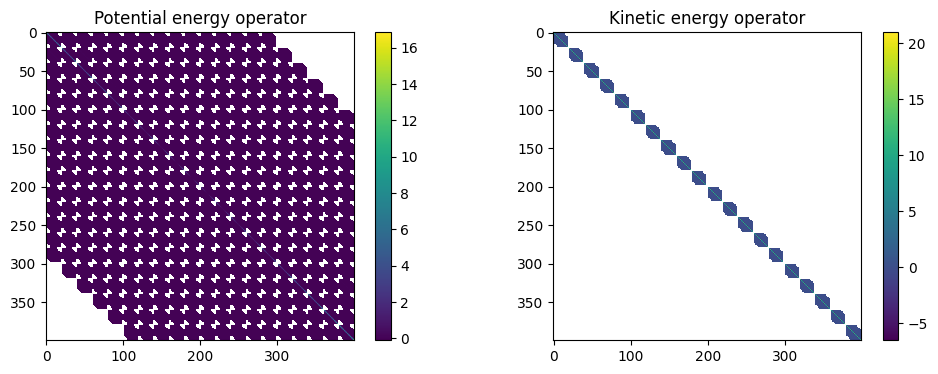

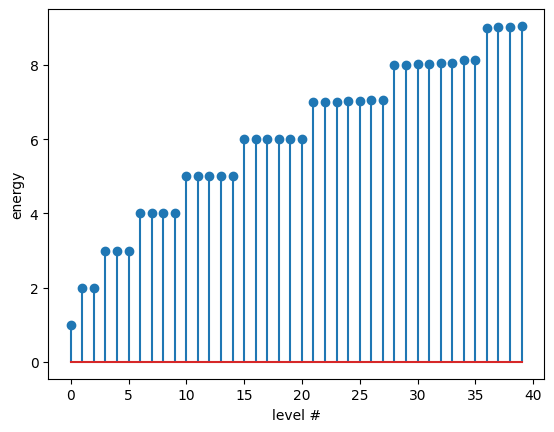

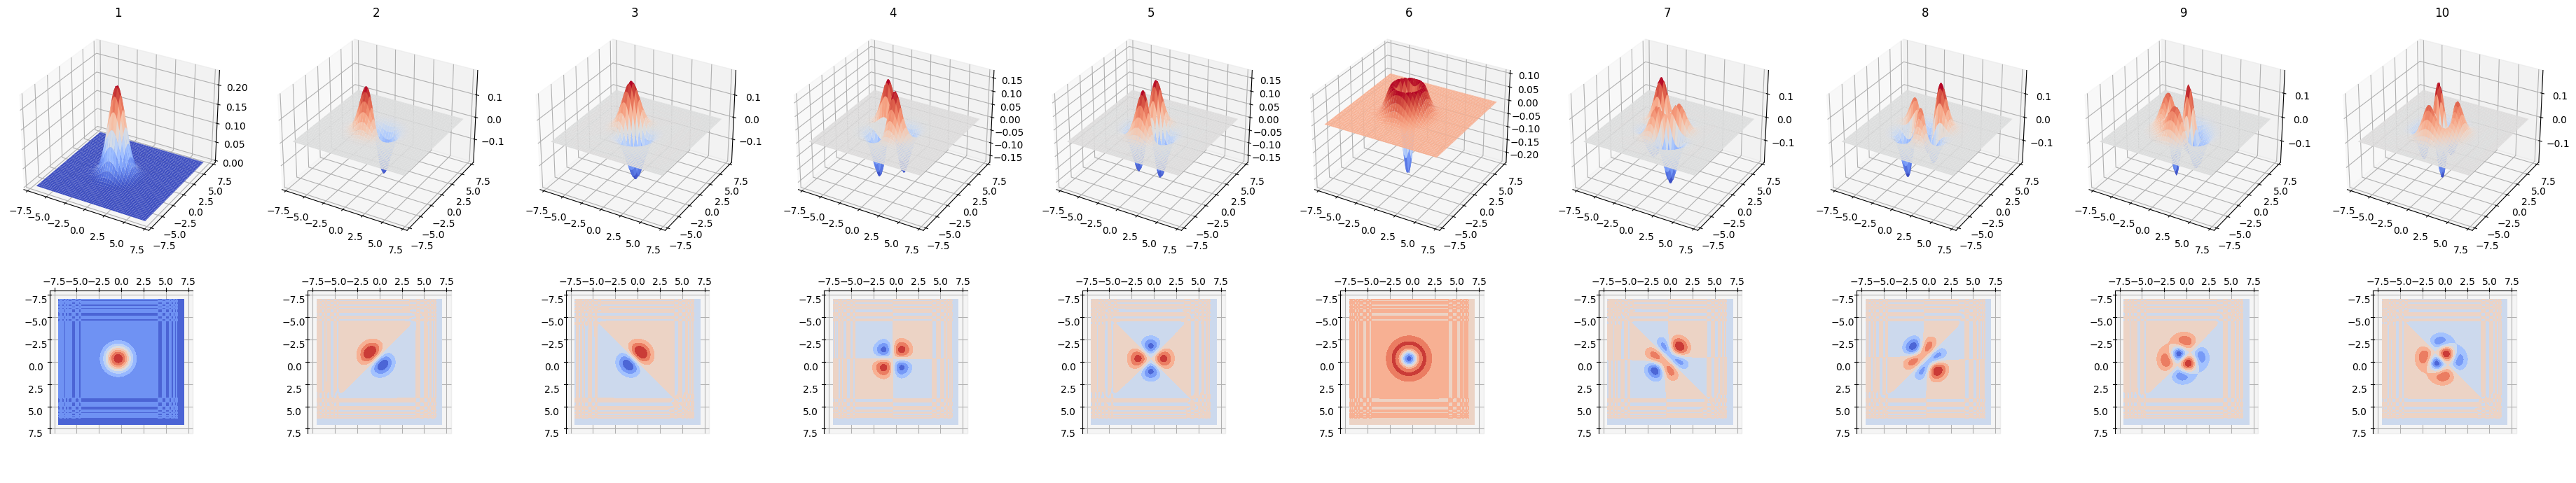

In [3]:
energies_20x20 = experiment(wvt_name="sym8", nsteps_x=20, nsteps_y=20)

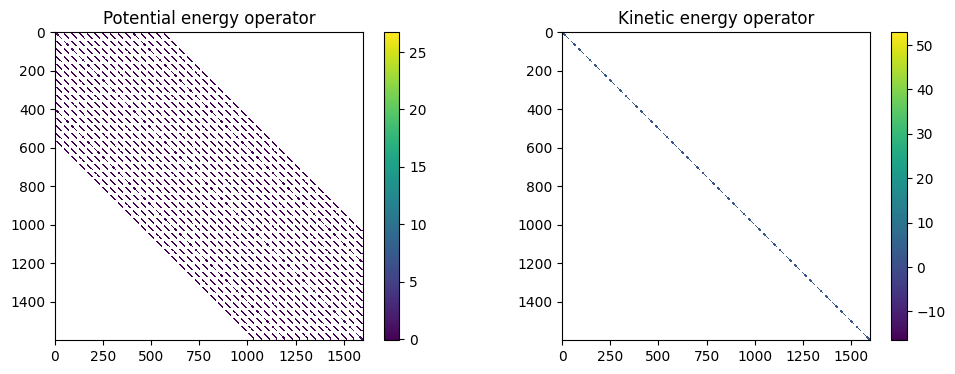

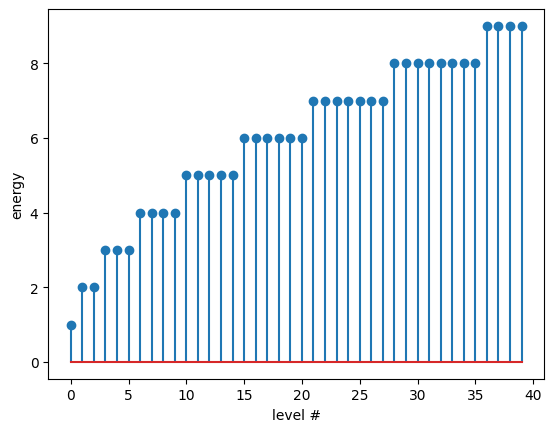

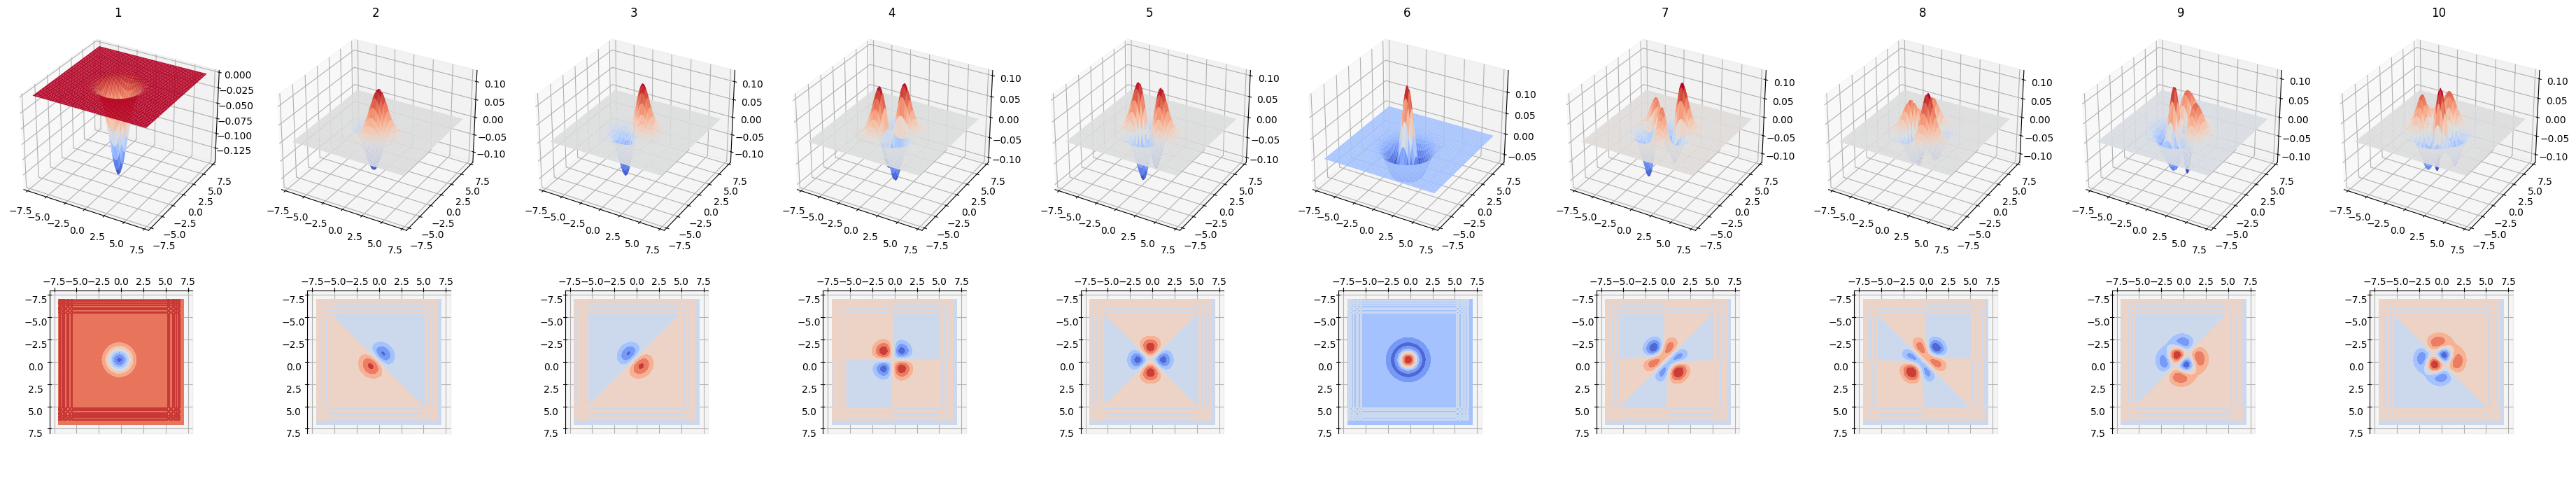

In [4]:
energies_40x40 = experiment(wvt_name="sym8", nsteps_x=40, nsteps_y=40)

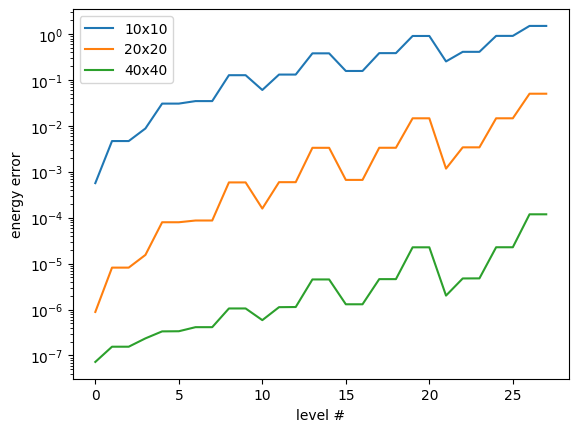

In [5]:
energies_gt = np.array([1.0] + 2 * [2.0] + 3 * [3.0] + 4 * [4.0] + 5 * [5.0] + 6 * [6.0] + 7 * [7.0])
plt.plot(energies_10x10[:len(energies_gt)] - energies_gt, label="10x10")
plt.plot(energies_20x20[:len(energies_gt)] - energies_gt, label="20x20")
plt.plot(energies_40x40[:len(energies_gt)] - energies_gt, label="40x40")
plt.xlabel("level #")
plt.ylabel("energy error")
plt.yscale("log")
plt.legend();